In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds

2024-07-24 10:11:05.862413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 10:11:06.036595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 10:11:06.086589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 10:11:06.468887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 10:11:09.333134: W tensorflow/compiler/tf2

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Loading and Preparation

In [27]:
DS_CONFIGS = {
    "cifar10": {"img_shape": (32, 32, 3), "num_labels": 10, "label_key": "label"},
    "cifar100": {"img_shape": (32, 32, 3), "num_labels": 20, "label_key": "coarse_label"}
}

DATASET = "cifar10"
LABEL_KEY = DS_CONFIGS[DATASET]["label_key"]

CIFAR_NUM_CLASSES = DS_CONFIGS[DATASET]["num_labels"]
CIFAR_IMAGE_SHAPE = DS_CONFIGS[DATASET]["img_shape"]

DATASET, LABEL_KEY, CIFAR_NUM_CLASSES, CIFAR_IMAGE_SHAPE

('cifar10', 'label', 10, (32, 32, 3))

In [28]:
train_ds, val_ds = tfds.load(DATASET, split=["train[:80%]", "train[80%:]"])
test_ds = tfds.load(DATASET, split="test")
len(train_ds), len(val_ds), len(test_ds)

(40000, 10000, 10000)

2024-07-24 10:19:07.355721: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<matplotlib.image.AxesImage at 0x15289b70df30>,
 <tf.Tensor: shape=(), dtype=int64, numpy=7>)

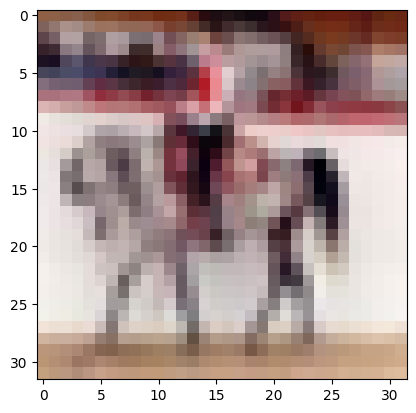

In [29]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [30]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element[LABEL_KEY]
        # image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image -> now done in the models
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(8)
            .batch(8)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(8)
        )

In [31]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

## Models

In [32]:
from models import get_lucasnet, get_simple_cnn, get_mobilenet, get_efficientnet

In [33]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy on {DATASET}')
    plt.show()

### Simple Convolutional Model

In [34]:
model = get_simple_cnn(CIFAR_IMAGE_SHAPE, CIFAR_NUM_CLASSES)

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.2895 - loss: 1.8908 - val_accuracy: 0.4821 - val_loss: 1.4367
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.4797 - loss: 1.4366 - val_accuracy: 0.5228 - val_loss: 1.3326
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5203 - loss: 1.3315 - val_accuracy: 0.5482 - val_loss: 1.2656
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5470 - loss: 1.2671 - val_accuracy: 0.5749 - val_loss: 1.1823
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5665 - loss: 1.2183 - val_accuracy: 0.5788 - val_loss: 1.1886
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5837 - loss: 1.1852 - val_accuracy: 0.5906 - val_loss: 1.1715
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5887 - loss: 1.1590 - val_accuracy: 0.5704 - val_loss: 1.2366
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5999 -

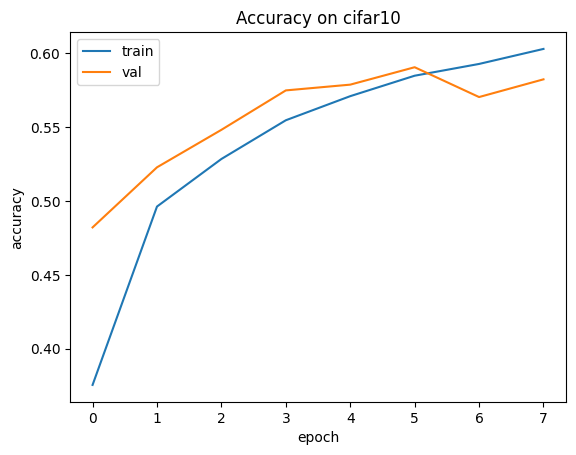

In [36]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### MobileNet

In [37]:
model = get_mobilenet(CIFAR_IMAGE_SHAPE, CIFAR_NUM_CLASSES)

Epoch 1/100


2024-07-24 10:22:29.845399: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_226', 248 bytes spill stores, 248 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_225', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion', 284 bytes spill stores, 284 bytes spill loads



5000/5000 ━━━━━━━━━━━━━━━━━━━━ 170s 24ms/step - accuracy: 0.3490 - loss: 1.8076 - val_accuracy: 0.4228 - val_loss: 2.3685
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 114s 23ms/step - accuracy: 0.5585 - loss: 1.2325 - val_accuracy: 0.3325 - val_loss: 4.4744
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 114s 23ms/step - accuracy: 0.6682 - loss: 0.9493 - val_accuracy: 0.5623 - val_loss: 1.7849
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - accuracy: 0.7251 - loss: 0.7914 - val_accuracy: 0.6179 - val_loss: 1.4823
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - accuracy: 0.7663 - loss: 0.6844 - val_accuracy: 0.7518 - val_loss: 0.7737
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - accuracy: 0.7995 - loss: 0.5959 - val_accuracy: 0.7589 - val_loss: 0.7550
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 23ms/step - accuracy: 0.8159 - loss: 0.5294 - val_accuracy: 0.7508 - val_loss: 0.8368
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - accuracy: 0.83

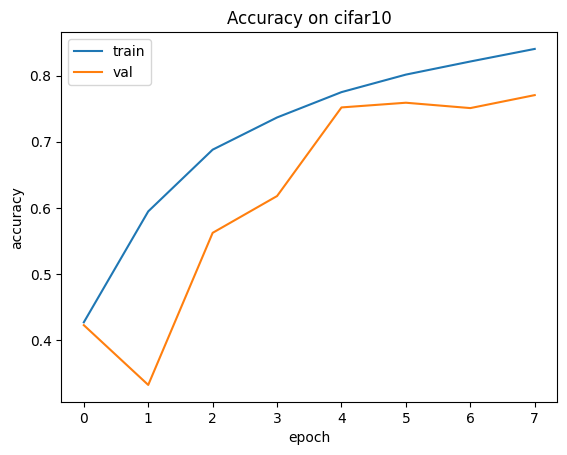

In [38]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### LL Architecture

In [40]:
model = get_lucasnet(CIFAR_IMAGE_SHAPE, CIFAR_NUM_CLASSES)

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.3993 - loss: 1.7416 - val_accuracy: 0.6027 - val_loss: 1.1542
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.6187 - loss: 1.0866 - val_accuracy: 0.6543 - val_loss: 1.0058
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6991 - loss: 0.8627 - val_accuracy: 0.6903 - val_loss: 0.9254
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7591 - loss: 0.6913 - val_accuracy: 0.7025 - val_loss: 0.8973
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8122 - loss: 0.5477 - val_accuracy: 0.7079 - val_loss: 0.8869
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8555 - loss: 0.4287 - val_accuracy: 0.7148 - val_loss: 0.8876
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8869 - loss: 0.3358 - val_accuracy: 0.7182 - val_loss: 0.9057
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7121 - loss: 0.8694

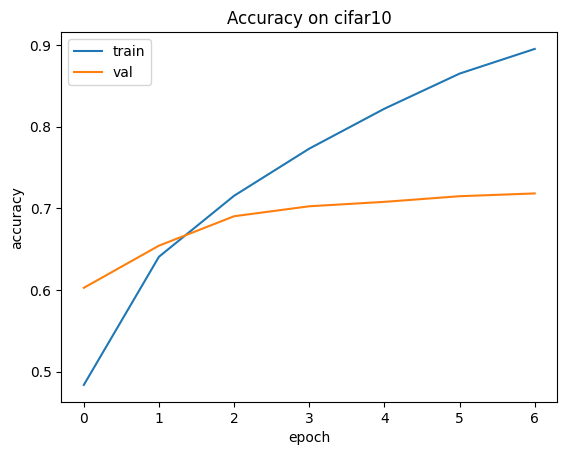

In [41]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)

### EfficientNet

EfficientNet gives good results, but requires around 10 times more training time than LL's architecture.

In [42]:
model = get_efficientnet(CIFAR_IMAGE_SHAPE, CIFAR_NUM_CLASSES)

Epoch 1/100


2024-07-24 10:51:56.916494: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 24 bytes spill stores, 24 bytes spill loads



5000/5000 ━━━━━━━━━━━━━━━━━━━━ 244s 30ms/step - accuracy: 0.2862 - loss: 2.1870 - val_accuracy: 0.5868 - val_loss: 1.1579
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.5553 - loss: 1.2765 - val_accuracy: 0.7023 - val_loss: 0.8470
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 202s 28ms/step - accuracy: 0.6612 - loss: 0.9910 - val_accuracy: 0.7543 - val_loss: 0.7067
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.7225 - loss: 0.8201 - val_accuracy: 0.7880 - val_loss: 0.6109
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.7587 - loss: 0.7103 - val_accuracy: 0.7923 - val_loss: 0.6071
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - accuracy: 0.7925 - loss: 0.6132 - val_accuracy: 0.8089 - val_loss: 0.5632
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - accuracy: 0.8173 - loss: 0.5340 - val_accuracy: 0.8173 - val_loss: 0.5547
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - accuracy: 0.83

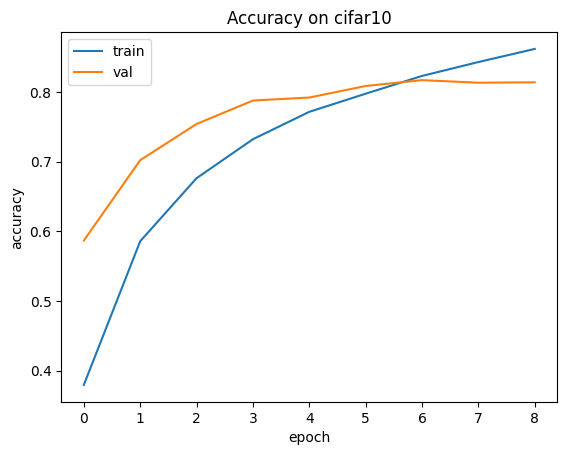

In [43]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
)
print(model.evaluate(test))
plot_history(history)